In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Uses the included data to calculate the impulse response of the Toyon antennas at various angles.
Credit for the main library goes to Zack Martin, I have just tidied up the IR calculation and 
pieced everything together across all the angles we have data for
-Will
"""

# Path set up
from pathlib import Path
HERE = Path('/home/william/Downloads/PUEO/will_antennas/').absolute()

# for quick importing reasons
import os
os.chdir(HERE)

import some_functions as sf
from waveform import waveform
from antenna_response import antenna_response as aresp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.constants import c
from scipy import interpolate, fft
import antennas

mpl.rcParams['xtick.labelsize']=18
mpl.rcParams['ytick.labelsize']=18
mpl.rcParams['axes.labelsize']=24
mpl.rcParams['lines.linewidth']=3
mpl.rcParams['patch.linewidth']=3
mpl.rcParams['legend.fontsize']=14
mpl.rcParams['axes.titlesize']=24
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['figure.figsize'] = 10, 5
mpl.rcParams['font.family'] = 'sans-serif'


In [2]:
# ---------------------------------
# -- FILE PARSING PARAMETERS
# ---------------------------------

from pathlib import Path
#HERE = Path('/home/william/Downloads/Antennas/').absolute()

# for quick importing reasons
import os
os.chdir(HERE)

# data path set up
DATA_DATE = "20220822"
PULSER_DATE = DATA_DATE #"20220816"
DATA_DIR = HERE / 'Data/{}/'.format(DATA_DATE)
print("DATA_DIR", DATA_DIR)
PULSER_DIR = HERE / 'Data/PULSER/{}/'.format(PULSER_DATE)
ALLDATA = np.array([file for file in DATA_DIR.glob('*.csv')] + [file for file in PULSER_DIR.glob('*.csv')])  # list of every data file name
# print("All data paths found: \n", ALLDATA)

# -- Now parse through the files to get the ones you want.
# Here's one way

# regex parsers (.* just means anything)
PULSER = "PULSE.*T1A.*Ch1"
Tx = "U.*"
Rx = "T1A.*"
POL = "VPOL"
DESC = ""
ANGLE = "([A-Z]*)[0-9]+" #"([A-Z]*)[0,30,60,90]"
TRIAL = "001"
TYPE = ".*Ch1"


# put it all together
if DESC == "":
    PARSER = "_".join([Tx,Rx,POL,ANGLE,TRIAL,TYPE])
else:
    PARSER = "_".join([Tx,Rx,POL,DESC,ANGLE,TRIAL,TYPE])

# use some_functions.re_search to regex find the files
# these are both an array of Paths, which you input into horn_response(), or feed each one into waveform()
PULSE_PATH = sf.re_search(PULSER, ALLDATA)
SIGNAL_PATHS = sf.re_search(PARSER, ALLDATA)
print(SIGNAL_PATHS, PULSE_PATH, PARSER)


DATA_DIR /home/william/Downloads/PUEO/will_antennas/Data/20220822
[PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_0_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_10_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_20_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_30_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_40_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_50_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_60_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_70_001_Ch1.csv')
 PosixPath('/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_80_001_Ch1.csv')
 PosixPa

In [8]:
#Just a happy little function to help us plot our impulse responses

def plot_imp_resp(horn_data, imp_resp, label=None):
    dt = horn_data.signals[0].samplerate
    imp_resp_t = [dt*i*1e9-20 for i in range(len(imp_resp))]
    plt.plot(imp_resp_t, imp_resp, lw=4, label=label)


/home/william/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning:

Casting complex values to real discards the imaginary part



Text(0, 0.5, 'Response [m/ns]')

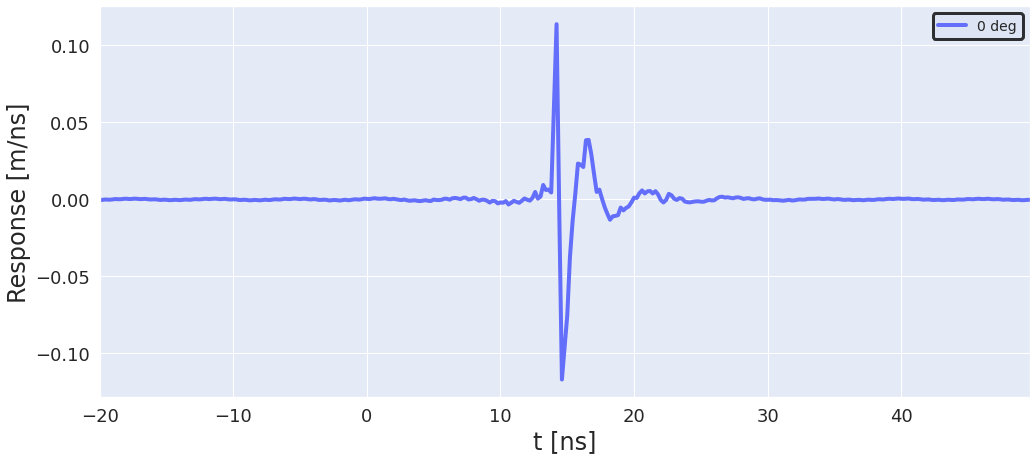

In [9]:
mpl.rcParams['figure.figsize'] = 16, 8


#Let's do this once for the boresight impulse response so you can see all the steps. 
#This is equivalent to the antenna_response.calc_imp_resp(angle=0) method that is
#in the included antenna_response class. 

out_arr = []
for ang in [0]:
    #Not accounting for frequency dependent distance
    dist = 10.5

    # Get the data and grab the ffts to get the freq domain info
    horn_data = aresp(PULSE_PATH, SIGNAL_PATHS)
    angle_data = horn_data.get_data_ang(angle=ang)
    fHz, pfft, _ = horn_data.pulse.calc_fft()
    _, sfft, _ = angle_data.calc_fft()
    
    #Frequency dependent factor in the impulse response formula
    phys = (dist * c) / (1j * fHz)

    #Wiener deconvolution and filtering
    fGHz_ordered = np.fft.fftshift(fHz)*1e-9
    fGHz_pos = fGHz_ordered[fGHz_ordered > 0]

    lowband1 = np.logical_and( 0<=fGHz_pos, fGHz_pos<0.15 )
    lowband2 = np.logical_and( 0.15<=fGHz_pos, fGHz_pos<0.3 )
    withinband = np.logical_and( 0.3<=fGHz_pos, fGHz_pos<=1.2 )
    aboveband1 = np.logical_and( 1.2<fGHz_pos, fGHz_pos<1.35 )
    aboveband2 = np.logical_and( 1.35<=fGHz_pos, fGHz_pos<np.inf )

    below1 = np.ones(len(fGHz_pos[lowband1]))
    below2 = np.linspace(1,1000,len(fGHz_pos[lowband2]),endpoint=True)
    within = 1000*np.ones(len(fGHz_pos[withinband]))
    above1 = np.linspace(1000,1,len(fGHz_pos[aboveband1]),endpoint=True)
    above2 = np.ones(len(fGHz_pos[aboveband2]))

    snr_pos = np.hstack((below1, below2, within, above1, above2))
    snr = np.hstack((snr_pos,np.flip(snr_pos)))

    pfft_eff = pfft / phys
    gfft = (1 / pfft_eff) * (1 / (1 + 1 / (np.abs(pfft_eff)**2 * snr)))
    IRfft2w = gfft * sfft

    # We now have h^2, now take the square root to get h
    # But be careful when picking which root to use! 
    # Want to use the same branch cut for all entries in the array
    # np.sqrt(complex) doesn't do this automatically, so we need to do it by hand

    IRfft2magw = np.abs(IRfft2w)
    IRfft2phiw = np.angle(IRfft2w)
    IRfft2phiunwrappedw =  np.unwrap(IRfft2phiw, period=np.pi)-np.pi

    # take the sqrt (half of the phase)

    phasesw = 0.5 * IRfft2phiunwrappedw
    IRfftw = np.sqrt(IRfft2magw) * np.exp(1j * phasesw)

    IRfftw = np.insert(IRfftw, 0, 0)
    imp_resp = np.fft.fftshift(np.fft.ifft(IRfftw))
    
    #plot and store in the info in one big array
    plot_imp_resp(horn_data, imp_resp, label='{0} deg'.format(ang))
    dt = horn_data.signals[0].samplerate
    imp_resp_t = [dt*i*1e9-20 for i in range(len(imp_resp))]
    out_arr.append([imp_resp_t, imp_resp])
    
out_arr = np.array(out_arr)
plt.legend(loc=1)
plt.xlabel('t [ns]')
plt.ylabel('Response [m/ns]')

/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_0_001_Ch1.csv
freq:  348
snr:  348
/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_10_001_Ch1.csv
freq:  348
snr:  348


/home/william/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/william/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning:

Casting complex values to real discards the imaginary part



/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_20_001_Ch1.csv
freq:  348
snr:  348
/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_30_001_Ch1.csv
freq:  348
snr:  348


/home/william/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/william/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning:

Casting complex values to real discards the imaginary part



/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_40_001_Ch1.csv
freq:  348
snr:  348
/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_50_001_Ch1.csv
freq:  348
snr:  348


/home/william/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/william/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning:

Casting complex values to real discards the imaginary part



/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_60_001_Ch1.csv
freq:  348
snr:  348
/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_70_001_Ch1.csv
freq:  348
snr:  348


/home/william/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/william/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning:

Casting complex values to real discards the imaginary part



/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_80_001_Ch1.csv
freq:  348
snr:  348
/home/william/Downloads/PUEO/will_antennas/Data/20220822/UCLA_to_T1A_VPOL_90_001_Ch1.csv
freq:  348
snr:  348


/home/william/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/william/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning:

Casting complex values to real discards the imaginary part



Text(0, 0.5, 'Response [m/ns]')

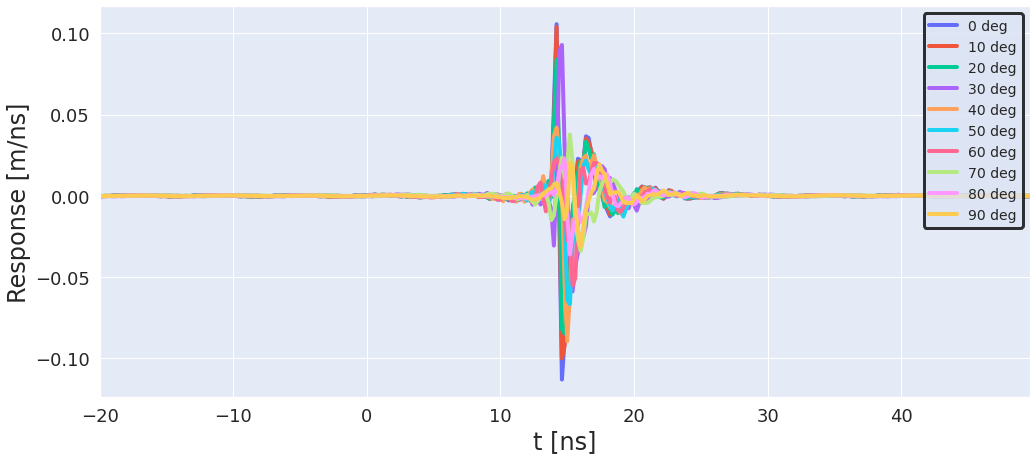

In [10]:
out_arr = []
for ang in [0,10,20,30,40,50,60,70,80,90]:
    #Not accounting for frequency dependent distance
    dist = 10.5

    horn_data = aresp(PULSE_PATH, SIGNAL_PATHS)
    imp_resp = horn_data.calc_imp_resp(angle=ang)
    
    dt = horn_data.signals[0].samplerate
    imp_resp_t = [dt*i*1e9-20 for i in range(len(imp_resp))]
    out_arr.append([imp_resp_t, imp_resp])
    
    plot_imp_resp(horn_data, imp_resp, label='{0} deg'.format(ang))
    
out_arr = np.array(out_arr)
#np.save('imp_resp_vs_angle.npy', out_arr)
plt.legend(loc=1)
plt.xlabel('t [ns]')
plt.ylabel('Response [m/ns]')